# NLP. Week 11. RNN with attention for translation


## RNN for Seq2Seq

Seq2Seq model or Sequence-to-Sequence model, is a machine learning architecture designed for tasks involving sequential data. It takes an input sequence, processes it, and generates an output sequence.

### Advantages of seq2seq Models

- Flexibility
- Handling sequential data
- Handling context
- Attention mechanism

### Disadvantages of seq2seq Models

- Computationally expensive
- Limited interpretability
- Overfitting
- Handling rare words
- Handling long input sequences

### Applications of Seq2Seq model

- Translation
- Text Summarization
- Speech Recognition
- Image Captioning

## Encoder decoder for translation

Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence. With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences. Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

### Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

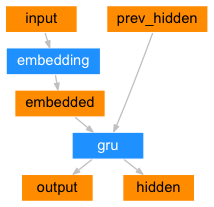

### Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<SOS>` token, and the first hidden state is the context vector (the encoder’s last hidden state).

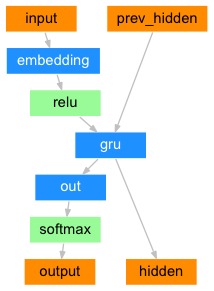

## Attention

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Bahdanau attention, also known as additive attention, is a commonly used attention mechanism in sequence-to-sequence models, particularly in neural machine translation tasks. It was introduced by Bahdanau et al. in their paper titled Neural Machine Translation by Jointly Learning to Align and Translate. This attention mechanism employs a learned alignment model to compute attention scores between the encoder and decoder hidden states. It utilizes a feed-forward neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as Luong attention, which computes attention scores by taking the dot product between the decoder hidden state and the encoder hidden states. It does not involve the non-linear transformation used in Bahdanau attention.


### Loading the data


In [1]:
import pandas as pd

train_df = pd.read_csv(
    "/kaggle/input/englishportuguese-translation/por.txt",
    sep="\t",
    usecols=[0, 1],
    names=["EN", "PR"],
)
train_df.head()

,EN,PR
0,Go.,Vai.
1,Go.,Vá.
2,Hi.,Oi.
3,Run!,Corre!
4,Run!,Corra!


### Preprocess


In [2]:
import unicodedata
import re


def unicode2ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


def normalize_string(s):
    s = unicode2ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [3]:
from tqdm import tqdm


def preprocess(texts):
    for text in tqdm(texts, desc="Building vocab"):
        tokens = normalize_string(str(text)).split()
        yield tokens

### Create vocabs


In [4]:
from torchtext.vocab import build_vocab_from_iterator

SPECIAL_TOKENS = ["<SOS>", "<EOS>", "<UNK>", "<PAD>"]
english_vocab = build_vocab_from_iterator(
    preprocess(train_df["EN"].values), special_first=True, specials=SPECIAL_TOKENS
)

port_vocab = build_vocab_from_iterator(
    preprocess(train_df["PR"].values), special_first=True, specials=SPECIAL_TOKENS
)

Building vocab: 100%|██████████| 168903/168903 [00:04<00:00, 35398.26it/s]


In [5]:
print("Length of english vocab:", len(english_vocab))
print("Length of portugese vocab:", len(port_vocab))

Length of english vocab: 12221
Length of portugese vocab: 20582


In [6]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_TOKEN_IDX = english_vocab["<SOS>"]
EOS_TOKEN_IDX = english_vocab["<EOS>"]
MAX_LENGTH = 100


def sentence2idxs(vocab, sentence):
    tokens = normalize_string(str(sentence)).split(" ")
    return [vocab[word] if word in vocab else vocab["<UNK>"] for word in tokens]


def sentence2tensor(vocab, sentence):
    indexes = sentence2idxs(vocab, sentence)
    indexes.append(EOS_TOKEN_IDX)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def process_sentence(vocab, sentence):
    idxs = sentence2idxs(vocab, sentence)
    idxs.append(EOS_TOKEN_IDX)
    return idxs


def get_dataloader(
    df, input_vocab, output_vocab, batch_size=64, in_column="EN", out_column="PR"
):

    n = len(df)
    input_idxs = np.ones((n, MAX_LENGTH), dtype=np.int32) * input_vocab["<PAD>"]
    target_idxs = np.ones((n, MAX_LENGTH), dtype=np.int32) * output_vocab["<PAD>"]

    for idx, row in tqdm(df.iterrows(), total=n):
        in_lang_idxs = process_sentence(input_vocab, row[in_column])
        out_lang_idxs = process_sentence(output_vocab, row[out_column])

        input_idxs[idx, : len(in_lang_idxs)] = in_lang_idxs
        target_idxs[idx, : len(out_lang_idxs)] = out_lang_idxs

    data = TensorDataset(
        torch.LongTensor(input_idxs).to(device),
        torch.LongTensor(target_idxs).to(device),
    )

    dataloader = DataLoader(data, batch_size=batch_size)
    return dataloader

### Encoder Decoder RNN Model


In [7]:
import torch.nn as nn


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [8]:
import torch.nn.functional as F


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device
        ).fill_(SOS_TOKEN_IDX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(
                decoder_input, decoder_hidden
            )
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(
                    -1
                ).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return (
            decoder_outputs,
            decoder_hidden,
            None,
        )  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Train


In [9]:
def train_epoch(
    dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion
):

    total_loss = 0
    for data in tqdm(dataloader):
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [10]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001):
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(n_epochs):
        loss = train_epoch(
            train_dataloader,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion,
        )
        print("Epoch:", epoch, "loss:", loss)

In [11]:
hidden_size = 128
batch_size = 64

train_dataloader = get_dataloader(
    train_df[:10000],
    batch_size=batch_size,
    input_vocab=english_vocab,
    output_vocab=port_vocab,
)

encoder = EncoderRNN(len(english_vocab), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(port_vocab)).to(device)

100%|██████████| 10000/10000 [00:01<00:00, 8725.63it/s]


In [12]:
train(train_dataloader, encoder, decoder, n_epochs=5)

100%|██████████| 157/157 [00:18<00:00,  8.66it/s]


Epoch: 0 loss: 0.9608244647265999


100%|██████████| 157/157 [00:16<00:00,  9.33it/s]


Epoch: 1 loss: 0.21218722299405723


100%|██████████| 157/157 [00:16<00:00,  9.32it/s]


Epoch: 2 loss: 0.19913442546774626


100%|██████████| 157/157 [00:16<00:00,  9.27it/s]


Epoch: 3 loss: 0.19054425522020668


100%|██████████| 157/157 [00:16<00:00,  9.28it/s]

Epoch: 4 loss: 0.1829584247557221


## Competition

[Competition](https://www.kaggle.com/t/ed002b89d14d4fee9d3903e85d4b0145)

> Goal of competition is to translate sentences from English to Dutch with Encoder-Decoder RNN with attention mechanism


In [ ]:
import pandas as pd

train_df = pd.read_csv("/kaggle/input/nlp-week-11-translation/train.csv")
train_df.head()

,id,EN,NL
0,0,I couldn't understand his joke.,Ik begreep zijn grap niet.
1,1,There was nothing Tom could do about it.,Er was niets dat Tom eraan kon doen.
2,2,He has a hat on.,Hij draagt een hoed.
3,3,Does that happen every time?,Gebeurt dat elke keer?
4,4,Please don't run in the classroom.,Alsjeblieft niet rennen in het klaslokaal.
